# Neuroimage Data Analysis using Python and Graph Neural Networks

**KHBM 2022 Winter School**

---

> 연세대학교 의과대학 

> 강남세브란스병원 정신건강의학과 김병훈 



<sup><sub>✔ 본 예제에서 수행하는 분석들은 해당 방법론을 소개하는 것에 그 목적이 있습니다.</sup> 

<sup><sub>✔ 따라서 본 예제에서 제시된 분석 결과들에 대한 해석은 추가적인 검증을 요할 수 있습니다.</sup>

## 파이썬을 이용한 뇌기능영상 기초 머신러닝

### 개발 환경 설정

#### Nilearn 설치

In [1]:
!pip install nilearn

     |████████████████████████████████| 10.1 MB 4.7 MB/s 


#### 라이브러리 불러오기

In [2]:
import numpy as np # numpy is for array operation
import pandas as pd # pandas is for dataframe operation
from nilearn import connectome, datasets, image, maskers, plotting
from tqdm import tqdm

### 분석 데이터 설정

#### 데이터셋 준비

##### 데이터셋 불러오기

In [3]:
# Prepare dataset
dataset = datasets.fetch_development_fmri(n_subjects=None, verbose=0)

print(f'> Dataset keys {dataset.keys()}')

print('> Dataset description')
print(dataset['description'])


Dataset created in /root/nilearn_data/development_fmri

> Dataset keys dict_keys(['func', 'confounds', 'phenotypic', 'description'])
> Dataset description
The movie watching based brain development dataset (fMRI)


Notes
-----
This functional MRI dataset is used for teaching how to use
machine learning to predict age from naturalistic stimuli (movie)
watching with Nilearn.

The dataset consists of 50 children (ages 3-13) and 33 young adults (ages
18-39). This dataset can be used to try to predict who are adults and
who are children.

The data is downsampled to 4mm resolution for convenience. The original
data is downloaded from OpenNeuro.

For full information about pre-processing steps on raw-fMRI data, have a look
at README at https://osf.io/wjtyq/

Full pre-processed data: https://osf.io/5hju4/files/

Raw data can be accessed from : https://openneuro.org/datasets/ds000228/versions/1.0.0

Content
-------
    :'func': functional MRI Nifti images (4D) per subject
    :'confounds': TSV

##### 데이터셋 확인하기

> Number of functional images: 155
> Shape of an example functional image: (50, 59, 50, 168)
> Plot of an example functional image


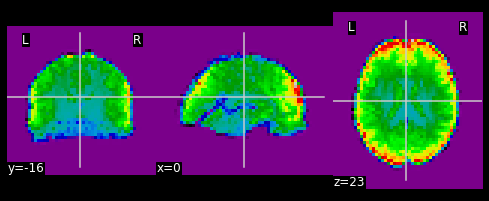

> Dataset phenotype dataframe


,participant_id,Age,AgeGroup,Child_Adult,Gender,Handedness
0,sub-pixar123,27.06,Adult,adult,F,R
1,sub-pixar124,33.44,Adult,adult,M,R
2,sub-pixar125,31.00,Adult,adult,M,R
3,sub-pixar126,19.00,Adult,adult,F,R
4,sub-pixar127,23.00,Adult,adult,F,R


In [4]:
# Explore dataset
print(f'> Number of functional images: {len(dataset["func"])}')

example_img = image.load_img(dataset['func'][0])
print(f'> Shape of an example functional image: {example_img.shape}')

print('> Plot of an example functional image')
plotting.plot_epi(image.mean_img(example_img))
plotting.show()

print('> Dataset phenotype dataframe')
df = pd.DataFrame(dataset['phenotypic'])
df.head()

#### 아틀라스 준비

##### 아틀라스 불러오기

In [5]:
# Prepare atlas
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=100, verbose=0)
print(f'> Atlas keys: {atlas.keys()}')

print('> Atlas description')
print(atlas['description'])

> Atlas keys: dict_keys(['maps', 'labels', 'description'])
> Atlas description
Schaefer 2018 Atlas


Notes
-----
This atlas provides a labeling of cortical voxels in the MNI152
space, see Schaefer et al. (2018). Each ROI is annotated with a
network from the Yeo parcellation (7- or 17-network solution; see
Yeo et al., 2011).


Different versions of the atlas are available, varying in
- number of rois (100 to 1000),
- network annotation (7 or 17)
- spatial resolution of the atlas (1 or 2 mm)

Content
-------
    :'maps': 3D Nifti image, values are indices in the list of labels.
    :'labels': ROI labels including Yeo-network annotation.
    :'description': A short description of the atlas and some references.

References
----------
For more information on this dataset, see
https://github.com/ThomasYeoLab/CBIG/tree/v0.8.1-Schaefer2018_LocalGlobal/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal

Schaefer A, Kong R, Gordon EM, Laumann TO, Zuo XN, Holmes AJ,
Eickhoff SB, Yeo BTT.

##### 아틀라스 확인하기

> Shape of the atlas image: (182, 218, 182)
> Plot of the atlas image


/usr/local/lib/python3.7/dist-packages/nilearn/plotting/img_plotting.py:348: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


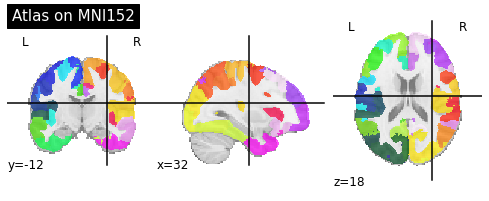

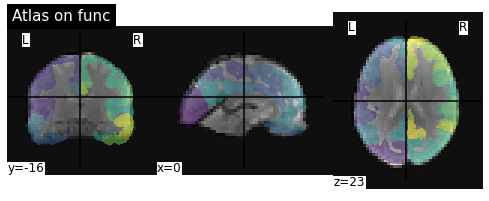

> Atlas label


,0
0,b'7Networks_LH_Vis_1'
1,b'7Networks_LH_Vis_2'
2,b'7Networks_LH_Vis_3'
3,b'7Networks_LH_Vis_4'
4,b'7Networks_LH_Vis_5'


In [6]:
# Explore atlas
atlas_img = image.load_img(atlas['maps'])
print(f'> Shape of the atlas image: {atlas_img.shape}')

print('> Plot of the atlas image')
plotting.plot_roi(atlas_img, title='Atlas on MNI152')
plotting.plot_img(image.mean_img(example_img), cmap='gray', title='Atlas on func').add_overlay(atlas_img, alpha=0.5)
plotting.show()

print('> Atlas label')
pd.DataFrame(atlas['labels']).head()

### 뇌기능 신호 도출하기

#### ROI-timeseries 행렬 도출

##### ROI-timeseries 행렬 도출하기

In [7]:
# Extract timeseries within the atlas ROIs
masker = maskers.NiftiLabelsMasker(labels_img=atlas_img, standardize='zscore', smoothing_fwhm=None)
masker.fit()

roi_timeseries_list = []
subject_list = []
for i, func in enumerate(tqdm(dataset['func'])):
  roi_timeseries = masker.transform(func, dataset['confounds'][i])
  roi_timeseries_list.append(roi_timeseries)
  subject_list.append(df['participant_id'][i])

100%|██████████| 155/155 [05:08<00:00,  1.99s/it]


##### ROI-timeseries 행렬 확인하기

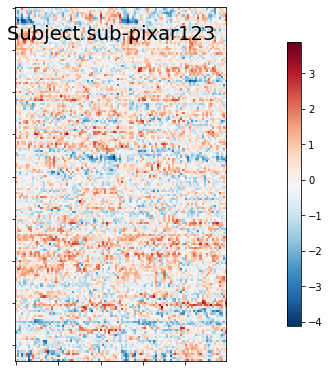

In [8]:
# Plot exemplar ROI-timeseries matrix
plotting.plot_matrix(roi_timeseries_list[0], title=f'Subject {subject_list[0]}')
plotting.show()

#### Functional connectivity (FC) 행렬 도출

##### FC 행렬 도출하기

In [9]:
# Construct functional connectivity matrix from the extracted ROI-Timeseries matrix
connectivity = connectome.ConnectivityMeasure(kind='correlation')
connectivity.fit(roi_timeseries_list)
fc_matrices = connectivity.transform(roi_timeseries_list)

##### FC 행렬 확인하기

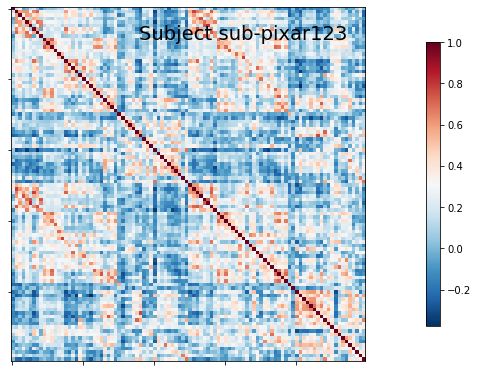

In [10]:
# Plot exemplar FC matrix
plotting.plot_matrix(fc_matrices[0], title=f'Subject {subject_list[0]}')
plotting.show()

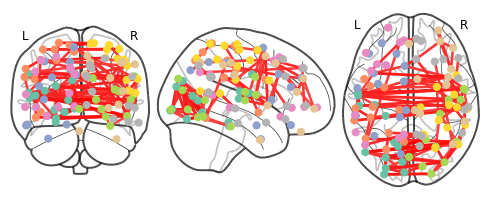

In [11]:
# Brainplot exemplar FC matrix
atlas_coords = plotting.find_parcellation_cut_coords(atlas['maps'])
plotting.plot_connectome(fc_matrices[0], atlas_coords, edge_threshold='98%')
plotting.show()

### 기초 머신러닝 

#### 라이브러리 불러오기

In [12]:
from sklearn import model_selection, preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context='notebook', style='white', font_scale=1.5)

#### 입력-라벨 데이터 만들기

##### 입력 데이터 X 구성
100 $\times$ 100 ROI간의 Functional connectivity 값의 크기

In [13]:
X = connectome.sym_matrix_to_vec(fc_matrices, discard_diagonal=True)

##### 라벨 데이터 y 구성
제공된 데이터셋 특징 중 'AgeGroup'

In [14]:
# Explore label data
print('> Count label distribution')
print(df['AgeGroup'].value_counts())

# Encode label classes into integers
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(df['AgeGroup'])
y = label_encoder.transform(df['AgeGroup'])
print('> Print encoded labels')
print(y)

> Count label distribution
5yo       34
8-12yo    34
Adult     33
7yo       23
3yo       17
4yo       14
Name: AgeGroup, dtype: int64
> Print encoded labels
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 1 1 1 1
 1 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 4 4
 3 3 3 4 3 3 4 3 4 3 4 4 4 4 4 4 4 3 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4
 3 4 4 4 4 4 3]


#### 모델 학습 및 평가
모델 종류: LogReg, SVM, RF, Dummy (baseline) 

평가 방법: Five-fold Stratified Cross validation의 Accuracy 평균 

In [15]:
result_dict = {}
estimator_dict = {}

# Four estimators with default hyperparamters
for estimator in [LogisticRegression(), SVC(), RandomForestClassifier(), DummyClassifier()]:
  model_name = str(estimator).rstrip('()')
  cv_result = model_selection.cross_validate(
    estimator, 
    X, 
    y, 
    scoring='accuracy', 
    return_estimator=True, 
    n_jobs=-1,
  ) # StratifiedKFold (k=5) used by default
  result_dict[model_name] = pd.DataFrame(cv_result).mean(numeric_only=True)
  estimator_dict[model_name] = cv_result['estimator']

result_df = pd.DataFrame(result_dict).T
result_df

,fit_time,score_time,test_score
LogisticRegression,0.934952,0.001340,0.574194
SVC,0.103307,0.027899,0.522581
RandomForestClassifier,0.570289,0.024445,0.529032
DummyClassifier,0.007117,0.000585,0.212903


#### 결과 시각화

##### 성능 그래프

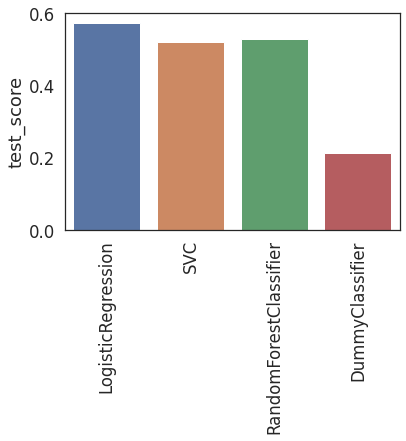

In [16]:
sns.barplot(data=result_df, x=result_df.index, y='test_score')
plt.xticks(rotation=90)
plt.show()

##### 입력요인 중요도 시각화
LogReg의 계수(Coefficient)를 시각화 하는 과정을 보임. 

Permutation Feature Importance, SHAP 등의 model-agnostic한 입력요인 중요도 계산법이 존재함.

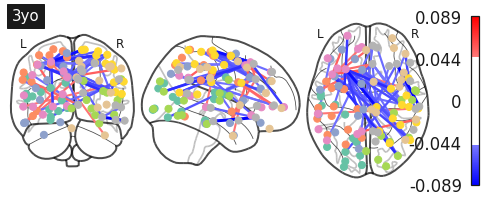

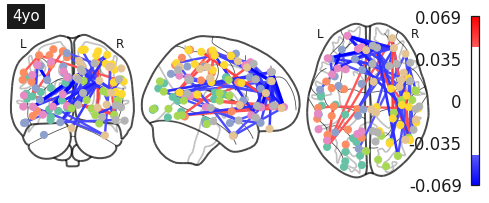

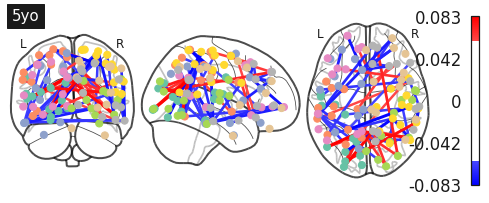

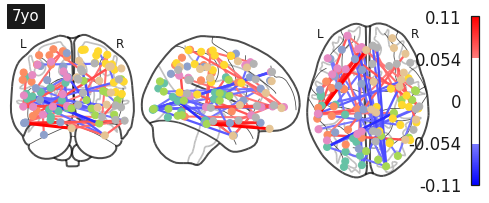

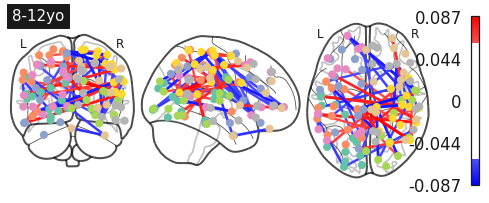

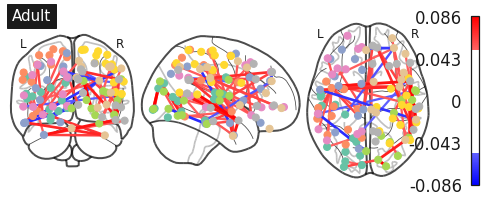

In [17]:
mean_coef = np.mean([estimator.coef_ for estimator in estimator_dict['LogisticRegression']], axis=0)
for label, coef in zip(label_encoder.classes_, mean_coef):
  plotting.plot_connectome(connectome.vec_to_sym_matrix(coef, diagonal=np.zeros(100)), atlas_coords, edge_threshold='99%', colorbar=True, title=label)
  plotting.show()

## 파이썬을 이용한 뇌기능영상 그래프 딥러닝

### 개발 환경 설정

#### torch_geometric 설치

In [18]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu113.html

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu113.html
     |████████████████████████████████| 7.9 MB 5.4 MB/s 
     |████████████████████████████████| 3.5 MB 37.7 MB/s 
     |████████████████████████████████| 2.3 MB 26.6 MB/s 
     |████████████████████████████████| 747 kB 6.5 MB/s 
     |████████████████████████████████| 370 kB 5.5 MB/s 
     |████████████████████████████████| 482 kB 45.5 MB/s 
     |████████████████████████████████| 41 kB 577 kB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.3-py3-none-any.whl size=581968 sha256=ed2ae070e545eb46d622c647fcab8ba03a1943e40e604623aa8f424897af0e54
  Stored in directory: /root/.cache/pip/wheels/c3/2a/58/87ce0508964d4def1aafb92750c4f3ac77038efd1b9a89dcf5
Successfully built torch-geometric


#### 라이브러리 불러오기

In [19]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv, global_mean_pool

#### 시드 설정

In [20]:
SEED = 42
torch.manual_seed(SEED)

### 데이터셋 준비

##### 입력-라벨 데이터 만들기
> X: node feature -> One-hot encoded ROIs 

> A: adjacency matrix -> Binarized FC 

> y: labels --> AgeGroup

In [21]:
# 기존 변수들을 재활용
X = np.repeat(np.expand_dims(np.eye(100),0), 150, axis=0) # Row: node index / Column: ROI label -> Identity matrix
A = fc_matrices # Unthresholded FC matrices
y = y # Encoded AgeGroup variable

##### Train-Validation-Test 스플릿

In [22]:
train_A, test_A, train_y, test_y = model_selection.train_test_split(A, y, test_size=0.15, random_state=SEED)
train_A, val_A, train_y, val_y = model_selection.train_test_split(train_A, train_y, test_size=0.15, random_state=SEED)
print('> Number of samples in each split')
print(f'train: {len(train_A)}')
print(f'val: {len(val_A)}')
print(f'test: {len(test_A)}')

> Number of samples in each split
train: 111
val: 20
test: 24


### 모델 준비

#### GCN 모델 클래스 구현

In [23]:
class GraphConvolutionalNetwork(nn.Module):
  def __init__(self, n_rois, n_classes, n_hidden=64):
    super().__init__()
    self.gconv1 = GCNConv(n_rois, n_hidden, add_self_loops=True)
    self.gconv2 = GCNConv(n_hidden, n_classes, add_self_loops=True)
    self.relu = nn.ReLU()
    
  def forward(self, x, edge_index, minibatch_index):
    h = self.gconv1(x, edge_index)
    h = self.relu(h)
    h = self.gconv2(h, edge_index)

    h_G = global_mean_pool(h, minibatch_index)
    
    return h_G

#### 모델 객체 정의

In [24]:
model = GraphConvolutionalNetwork(n_rois=100, n_classes=6)

### 학습 준비

#### 하이퍼파라미터 세팅

In [25]:
minibatch_size = 16
num_epochs = 150
lr = 0.01

#### 목적함수, Optimizer 정의

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

#### 데이터 전처리 함수 구현

In [27]:
def binarize_connectivity(A, sparsity):
  A -= 2*np.eye(len(A))
  return (A > np.percentile(A, 100-sparsity)).astype(int)

def get_minibatch_adjacency(A):
  """
  Aggregate subject-stacked adjacency matrices of shape [B, N, N] to one large
  adjacency matrices of shape [B*N, B*N] with between-subject edges unconnected.
  """
  
  minibatch_index = [i*np.ones(len(_A)) for i, _A in enumerate(A)]
  minibatch_length = len(np.concatenate(minibatch_index))
  minibatch_adjacency = np.zeros([minibatch_length, minibatch_length]) # zero matrix로 초기화
  start_index = 0
  for idx, _A in zip(minibatch_index, A):
    minibatch_adjacency[start_index:start_index+len(idx), start_index:start_index+len(idx)] = _A
    start_index += len(idx)
  
  return minibatch_adjacency, np.concatenate(minibatch_index)

#### 학습 함수 구현

In [28]:
def train(A, y, model, criterion, optimizer, scheduler, minibatch_size=16, sparsity=30):
  # 모델을 학습 모드로 설정
  model.train()

  # 미니배치 샘플링을 위한 인덱스 정의
  sampling_index = np.arange(len(A))
  np.random.shuffle(sampling_index) # 학습 데이터의 경우 입력 순서를 shuffling함.
  minibatch_sampling_index = np.array_split(sampling_index, len(A)//minibatch_size)

  # 전체 데이터의 지표 파악을 위한 데이터 보관 변수 정의
  loss_list = []
  correct = 0

  # 미니배치 기준의 학습 반복문
  for i in minibatch_sampling_index:
    # 모델의 .forward()는 x, edge_index, minibatch_index 를 argument로 받음.
    
    # 1> x 정의
    minibatch_X = X[i] # X로부터 미니배치 인덱스 샘플링
    minibatch_X = np.concatenate([_X for _X in minibatch_X]) # [B, N, F] -> #[B*N, F]
    x = torch.Tensor(minibatch_X) # torch.Tensor로 변환하여 x를 정의

    # 2> edge_index 정의
    minibatch_A = A[i] # A로부터 미니배치 인덱스 샘플링
    minibatch_A = [binarize_connectivity(_A, sparsity=sparsity) for _A in minibatch_A] # binarize
    minibatch_A, minibatch_index = get_minibatch_adjacency(minibatch_A) # [B, N, N] -> [B*N, B*N]
    edge_index = torch.Tensor(minibatch_A).to_sparse().indices() # torch.Tensor로 변환 후 edge_index를 정의
    
    # 3> minibatch_index 정의
    minibatch_index = torch.Tensor(minibatch_index).long() # torch.Tensor로 변환하여 minibatch_index를 정의

    # 라벨 정의
    minibatch_y = torch.Tensor(train_y[i]).long()

    # 모델 추론
    logit = model(x=x, edge_index=edge_index, minibatch_index=minibatch_index)
    loss = criterion(logit, minibatch_y)

    # Backpropagation을 이용한 학습
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # 모델 평가를 위한 지표 저장
    pred = logit.argmax(dim=1)
    correct += (pred==minibatch_y).sum()
    loss_list.append(loss.detach())

  # epoch마다 lr 스케쥴 진행
  scheduler.step()

  # 지표 통합
  loss = np.mean(loss_list)
  accuracy = correct/len(A)
  
  return loss, accuracy

#### 평가 함수 구현

In [29]:
def eval(A, y, model, sparsity=30):
  # 모델을 평가 모드로 설정
  model.eval()

  # 전체 데이터의 지표 파악을 위한 데이터 보관 변수 정의
  loss_list = []
  correct = 0

  # 단일 샘플 기준의 학습 반복문 (minibatch_size=1 과 동일)
  for _X, _A, _y in zip(X, A, y):
    # 모델의 .forward()는 x, edge_index, minibatch_index 를 argument로 받음.

    # 1> x 정의
    x = torch.Tensor(_X) # torch.Tensor로 변환하여 x를 정의

    # 2> edge_index 정의
    _A = binarize_connectivity(_A, sparsity=sparsity) # binarize
    edge_index = torch.Tensor(_A).to_sparse().indices() # torch.Tensor로 변환 후 edge_index를 정의

    # 3> minibatch_index 정의
    minibatch_index = torch.zeros(len(_A)).long() # 미니배치가 하나이므로 모든 노드를 0번째 미니배치로 배정

    # 라벨 정의
    _y = torch.Tensor([_y]).long()

    # 모델 추론 및 지표 저장
    logit = model(x=x, edge_index=edge_index, minibatch_index=minibatch_index)
    loss = criterion(logit, _y)
    pred = logit.argmax(dim=1)
    correct += (pred==_y).sum()
    loss_list.append(loss.detach())
  
  # 지표 통합
  loss = np.mean(loss_list)
  accuracy = correct/len(A)
    
  return loss, accuracy

### 모델 학습

#### 모델 학습 시행

In [30]:
# 지표 평가를 위한 리스트 정의
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

# 정해진 epoch 기준의 학습 반복문
for epoch in tqdm(range(num_epochs)):
  # train
  train_loss, train_acc = train(train_A, train_y, model, criterion, optimizer, scheduler, minibatch_size=minibatch_size)
  train_loss_list.append(train_loss)
  train_acc_list.append(train_acc)

  # validate
  val_loss, val_acc = eval(val_A, val_y, model)
  val_loss_list.append(val_loss)
  val_acc_list.append(val_acc)

100%|██████████| 150/150 [02:05<00:00,  1.19it/s]


#### 모델 학습 과정 시각화

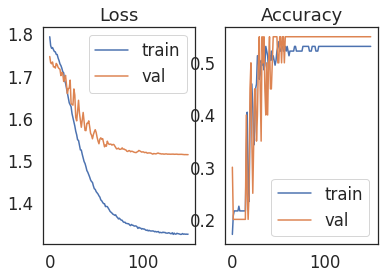

In [31]:
fig, ax = plt.subplots(ncols=2)
ax[0].plot(np.arange(num_epochs), train_loss_list, label='train')
ax[0].plot(np.arange(num_epochs), val_loss_list, label='val')
ax[0].legend()
ax[0].set_title('Loss')

ax[1].plot(np.arange(num_epochs), train_acc_list, label='train')
ax[1].plot(np.arange(num_epochs), val_acc_list, label='val')
ax[1].legend()
ax[1].set_title('Accuracy')

plt.show()

### 모델 성능 평가

#### 테스트 데이터로 모델 평가

In [32]:
test_loss, test_acc = eval(test_A, test_y, model)

#### 모델 성능 평가 결과 시각화

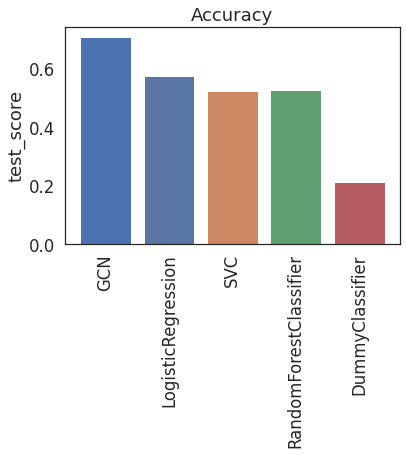

In [33]:
ax = sns.barplot(data=result_df, x=result_df.index, y='test_score') # 기초 머신러닝 방법들 시각화
ax.bar(-1, test_acc) # -1에 해당하는 x축 위치에 test_acc 를 barplot
ax.set_title('Accuracy')
plt.xticks(ticks=np.arange(-1,4), labels=['GCN']+result_df.index.to_list(), rotation=90)
plt.show()
# [!] GCN result is not cross-validated